# 构建LeNet-5模型
LeNet-5模型是 Yann LeCun 教授于1998年在论文<<Gradient-based learning applied to document recognition>>中提出的，
它是第一个成功用于数字识别问题的卷积神经网络。在MNIST数据集上，LeNet-5模型可以达到大约99.2%的正确率。
<br>LeNet-5模型总共有七层，模型结构如下所示，此图结构需要调整：
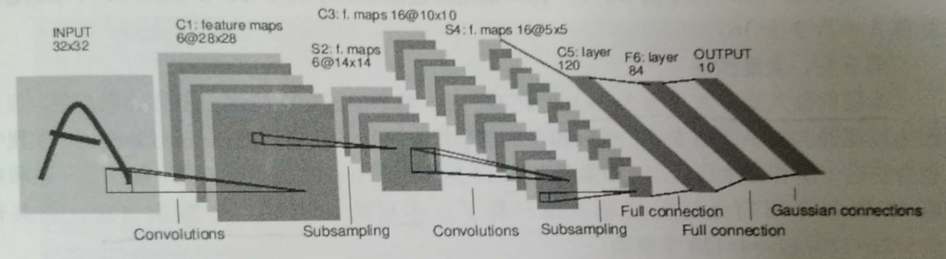

In [1]:
import tensorflow as tf

#### 1. 设定神经网络的参数

In [3]:
# 配置全连接层网络参数
INPUT_NODE = 784

# 定义图片尺寸和深度
IMAGE_SIZE = 28  # 尺寸
NUM_CHANNELS = 1 # 图片深度
NUM_LABELS = 10

# 第一层卷积层的尺寸和深度
CONV1_DEEP = 32
CONV1_SIZE = 5

# 第二层卷积层的尺寸和
CONV2_DEEP = 64
CONV2_SIZE = 5

# 全连接层节点个数
FC_SIZE = 512
OUTPUT_NODE = 10

#### 2. 定义前向传播的过程

In [3]:
# 定义卷积审计网络的前向传播过程
# 在这个程序中，将使用dropout方法，dropout可以进一步提升模型可靠性并防止过拟合
# dropout的过程只在训练的时候使用
def inference(input_tensor, train, regularizer):
    # 声明第一层卷积层的变量并实现前向传播过程。
    # 通过使用不同的命名空间来隔离不同层的变量，这可以让每一层中的变量名只需要在当前层的作用，而不需要担心重名的问题
    # 和标准的LeNet-5模型不一样，这里定义的卷积层输入为28*28*1的原始MNIST问题
    # 因为卷积层中使用全零填充，所以输出为32@28*28的矩阵。
    with tf.variable_scope('layer1-conv1'):
        # 定义第一层卷积核
        conv1_weights = tf.get_variable(
            "weight", 
            shape=[CONV1_SIZE, CONV1_SIZE, NUM_CHANNELS, CONV1_DEEP],
            initializer=tf.truncated_normal_initializer(stddev=0.1))
        # 定义第一层卷积核偏置项
        conv1_biases = tf.get_variable("bias", shape=[CONV1_DEEP], initializer=tf.constant_initializer(0.0))
        
        # 计算第一层卷积层的前向传播过程以及结果
        # 过滤器步长为1，使用全0填充
        conv1 = tf.nn.conv2d(input_tensor, conv1_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))

    # 实现第二层池化层的前向传播过程：这一层得到的矩阵为32@14*14
    with tf.name_scope("layer2-pool1"):
        # 池化层过滤器边长为2，移动步长为2，使用全零填充
        pool1 = tf.nn.max_pool(relu1, ksize = [1,2,2,1],strides=[1,2,2,1],padding="SAME")

    # 申明第三次卷积层的变量并实现前向传播的过程：这一层的输出矩阵为64@14*14
    with tf.variable_scope("layer3-conv2"):
        conv2_weights = tf.get_variable(
            "weight", 
            shape=[CONV2_SIZE, CONV2_SIZE, CONV1_DEEP, CONV2_DEEP],
            initializer=tf.truncated_normal_initializer(stddev=0.1))
        conv2_biases = tf.get_variable("bias", shape=[CONV2_DEEP], initializer=tf.constant_initializer(0.0))
        conv2 = tf.nn.conv2d(pool1, conv2_weights, strides=[1, 1, 1, 1], padding='SAME')
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
    
    # 申明第四层池化层的前向传播过程：输出为64@7*7的矩阵
    with tf.name_scope("layer4-pool2"):
        # 过滤器边长为2，移动步长为2，使用全0填充
        pool2 = tf.nn.max_pool(relu2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        # 将第四层池化层的输出转化为第五层全连接层的输入
        # 第四层的输出为64@7*7的矩阵，然而第五层的输入格式为向量，所以在这里需要将矩阵拉成一个向量
        # pool2.get_shape函数可以得到第四层输出格式的维度而不需要手工计算。
        # 注意因为每一层神经网络的输入输出都为一个batch的矩阵，所以这里得到的维度也包含了batch中数据的个数
        pool_shape = pool2.get_shape().as_list()
        # 计算将矩阵拉成向量之后的长度，这个长度就是矩阵长宽以及深度的乘积。
        # 注意这里pool_shape[0]为一个batch中数据的个数
        nodes = pool_shape[1] * pool_shape[2] * pool_shape[3]
        # 通过tf.reshape函数将第四层的输出变成一个batch的向量
        reshaped = tf.reshape(pool2, [pool_shape[0], nodes])
        
    # 申明第五层全连接层的变量并实现前向传播过程。
    # 这一层的输入是拉直后的一组向量长度为7*7*64=3136,输出是一组长度为512的向量。
    # 此处引入了dropout，dropout在训练时会随机将部分节点的输出改为0。
    # dropout可以避免过拟合问题，从而使得模型在测试数据上的效果更好。
    # dropout一般只在全连接层而不是卷积层或者池化层使用。
    with tf.variable_scope('layer5-fc1'):
        # 定义第五层全连接层参数
        fc1_weights = tf.get_variable("weight", 
                                      shape=[nodes, FC_SIZE],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
        # 只有全连接层的权重需要加入正则化
        if regularizer != None: 
            tf.add_to_collection('losses', regularizer(fc1_weights))
        fc1_biases = tf.get_variable("bias", shape=[FC_SIZE], initializer=tf.constant_initializer(0.1))

        fc1 = tf.nn.relu(tf.matmul(reshaped, fc1_weights) + fc1_biases)
        if train: 
            fc1 = tf.nn.dropout(fc1, 0.5)
    
    # 申明第六层全连接层的变量并实现前向传播过程
    # 这一层的输入为一组长度为512的向量，输出为一组长度为10的向量。
    # 这一层的输出通过Sofmax之后就得到了最后的分类结果。
    with tf.variable_scope('layer6-fc2'):
        fc2_weights = tf.get_variable("weight", 
                                      shape=[FC_SIZE, NUM_LABELS],
                                      initializer=tf.truncated_normal_initializer(stddev=0.1))
        # 把全连接参数添加上正则化
        if regularizer != None: 
            tf.add_to_collection('losses', regularizer(fc2_weights))
        fc2_biases = tf.get_variable("bias", shape=[NUM_LABELS], initializer=tf.constant_initializer(0.1))
        logit = tf.matmul(fc1, fc2_weights) + fc2_biases
    
    # 返回第六层的输出
    return logit